In [1]:
# force geopandas to use shapely instead of pygeos
import os
os.environ['USE_PYGEOS'] = '0'

import numpy as np
import pandas as pd
import plotly.express as px
from shapely import wkt
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# turns a list of lists into one big list
def flatten(l):
    return [item for sublist in l for item in sublist]

## Read in enforcement + illegal counts and illegal counts files

Final probability is going to be $P(E|I) = \frac{P(E\cap I)}{P(I)}$.

In [3]:
joined = pd.read_csv('../data/joined.csv')
count_e_and_i = pd.read_csv("../data/count_E_and_I.csv")
count_i = pd.read_csv("../data/count_I.csv")

In [4]:
street_names = count_i["street_id"].unique()

In [5]:
# creating multi index
count_i = count_i.set_index(["street_id", "weekday"])

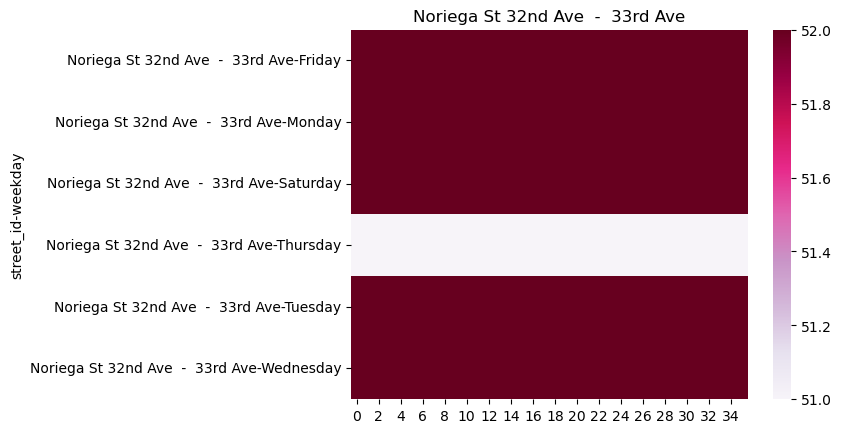

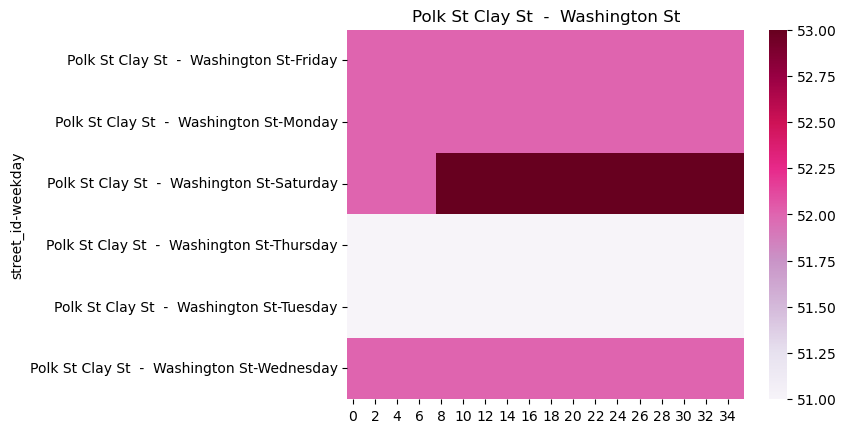

In [6]:
# plot counts of illegal parking on each street

for street_id in street_names:
    slc = count_i.iloc[count_i.index.get_level_values('street_id') == street_id]
    sns.heatmap(slc, cmap = "PuRd").set(title=street_id)
    plt.show()

In [7]:
# list of each street 7 times (one for each day of the week)

streets = flatten([[name]*7 for name in joined["street_id"].unique()])

In [8]:
# creates multi index of each (street segment, day of week)

arrays = [streets, ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]*len(joined["street_id"].unique())]

tuples = list(zip(*arrays))
new_idx = pd.MultiIndex.from_tuples(tuples, names=["streets", "days"])

In [9]:
# rename columns and set index to streets and weekday

count_e_and_i = count_e_and_i.rename(columns={"street_id": "streets", "citation_day": "days"}).set_index(['streets', 'days'])

In [10]:
# reindex to new index

count_i = count_i.reindex(new_idx, fill_value=0)
count_e_and_i = count_e_and_i.reindex(new_idx, fill_value=0)

In [21]:
# do division to get final probability
e_given_i = count_e_and_i.divide(count_i.values).fillna(0).reset_index()

In [12]:
# if divide by 0, probability is 0

e_given_i.replace([np.inf], 0, inplace=True)

## Select Streets for Comparison

In [16]:
two_streets = e_given_i[(e_given_i.streets == 'Polk St Clay St  -  Washington St') | (e_given_i.streets == 'Noriega St 32nd Ave  -  33rd Ave')]
(two_streets[[col for col in two_streets.columns if col not in ['streets', 'days']]] > 1).any(axis=1).sum()

0

In [17]:
two_streets = two_streets.set_index('days')

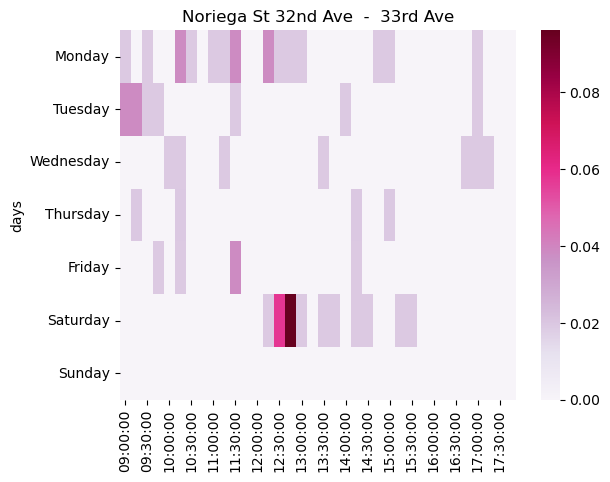

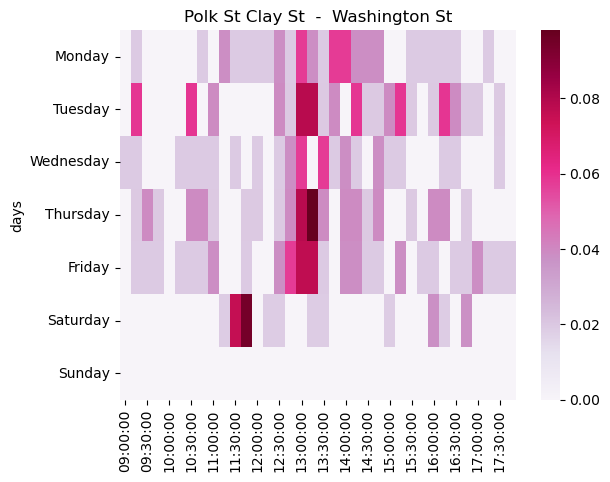

In [18]:
# plots of final probabilities

for street_id in sorted(two_streets.streets.unique()):
    sns.heatmap(two_streets[two_streets.streets == street_id].drop(['streets'], axis=1), cmap = "PuRd").set(title=street_id)
    plt.show()